In [8]:
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

In [9]:
# Read the file in which the values are saved
appa2 = pd.read_csv("../../exports/appa2_shrinked.csv")
appa2 = appa2.drop('Unnamed: 0', axis=1)

In [10]:
#selecting all the values we need to train and test the model
appa2 = appa2[[
    'LaFeO3_1', 'LaFeO3_2', 
    'STN_1', 'STN_2', 
    'LaFeO3_1_heatR', 'LaFeO3_2_heatR',
    'STN_1_heatR', 'STN_2_heatR', 
    'Temperature', 'Relative_Humidity', 'Pressure', 'VOC', 
    'Wind_Speed', 
    'PM10', 'CO', 'NO2'
]]

# Random Forest

In [11]:
# Select the features
cols = [
    'LaFeO3_1', 'LaFeO3_2', 
    'STN_1', 'STN_2', 
    'LaFeO3_1_heatR', 'LaFeO3_2_heatR',
    'STN_1_heatR', 'STN_2_heatR', 
    'Temperature', 'Relative_Humidity', 'Pressure', 'VOC', 
    'Wind_Speed'
]

# Select the target
outs = ['PM10', 'CO', 'NO2']

In [12]:
# Split the values in training and test
vsplit = round(len(appa2) * 0.2)

X_train = appa2.iloc[vsplit:][cols]
X_test = appa2.iloc[:vsplit][cols]

Y_train = appa2.iloc[vsplit:][outs]
Y_test = appa2.iloc[:vsplit][outs]

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start= 100, stop= 2000, num=10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [14]:
# Choose the type of model
model = RandomForestRegressor()

In [15]:
# Perform the RandomForestRegression with a Random Search on hyperparameters
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=3, verbose=2,
                               random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [16]:
# Create a Dataframe with the results of the model and then saving them into a .csv file
ris = pd.DataFrame(rf_random.cv_results_)
ris.to_csv('results/results_weather1_shrinked(1).csv')

In [17]:
# Save the model itself in a .sav file
pickle.dump(rf_random, open('models/model_weather1_shrinked(1).sav', 'wb'))

## Results

In [32]:
# rf_random = pickle.load(open("random_forest2_gridsearch_weather.sav", "rb"))
# rf_random

In [24]:
def percentage(mean_abs_err, describer):
    perc = mean_abs_err / (describer.max() - describer.min())
    return perc * 100

In [33]:
print("PM10: " + str(percentage(mean_absolute_error(Y_test.PM10 , rf_random.predict(X_test)[: ,0]), Y_test.PM10.describe())))
print("CO: " + str(percentage(mean_absolute_error(Y_test.CO , rf_random.predict(X_test)[: ,1]), Y_test.CO.describe())))
print("NO2: " + str(percentage(mean_absolute_error(Y_test.NO2 , rf_random.predict(X_test)[: ,2]), Y_test.NO2.describe())))
print("Total: \n" + str(percentage(mean_absolute_error(Y_test, rf_random.predict(X_test)), Y_test.describe())))

PM10: 3.237149878212384
CO: 0.039637638370962444
NO2: 3.1953723518849966
Total: 
PM10    2.147533
CO      2.138666
NO2     2.167698
dtype: float64


## Hyperparameters Plots

In [34]:
# ris = pd.read_csv("risultati2_weather1.csv")
# ris.columns

C:\Users\gabri\AppData\Local\Temp\ipykernel_7636\2108796386.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


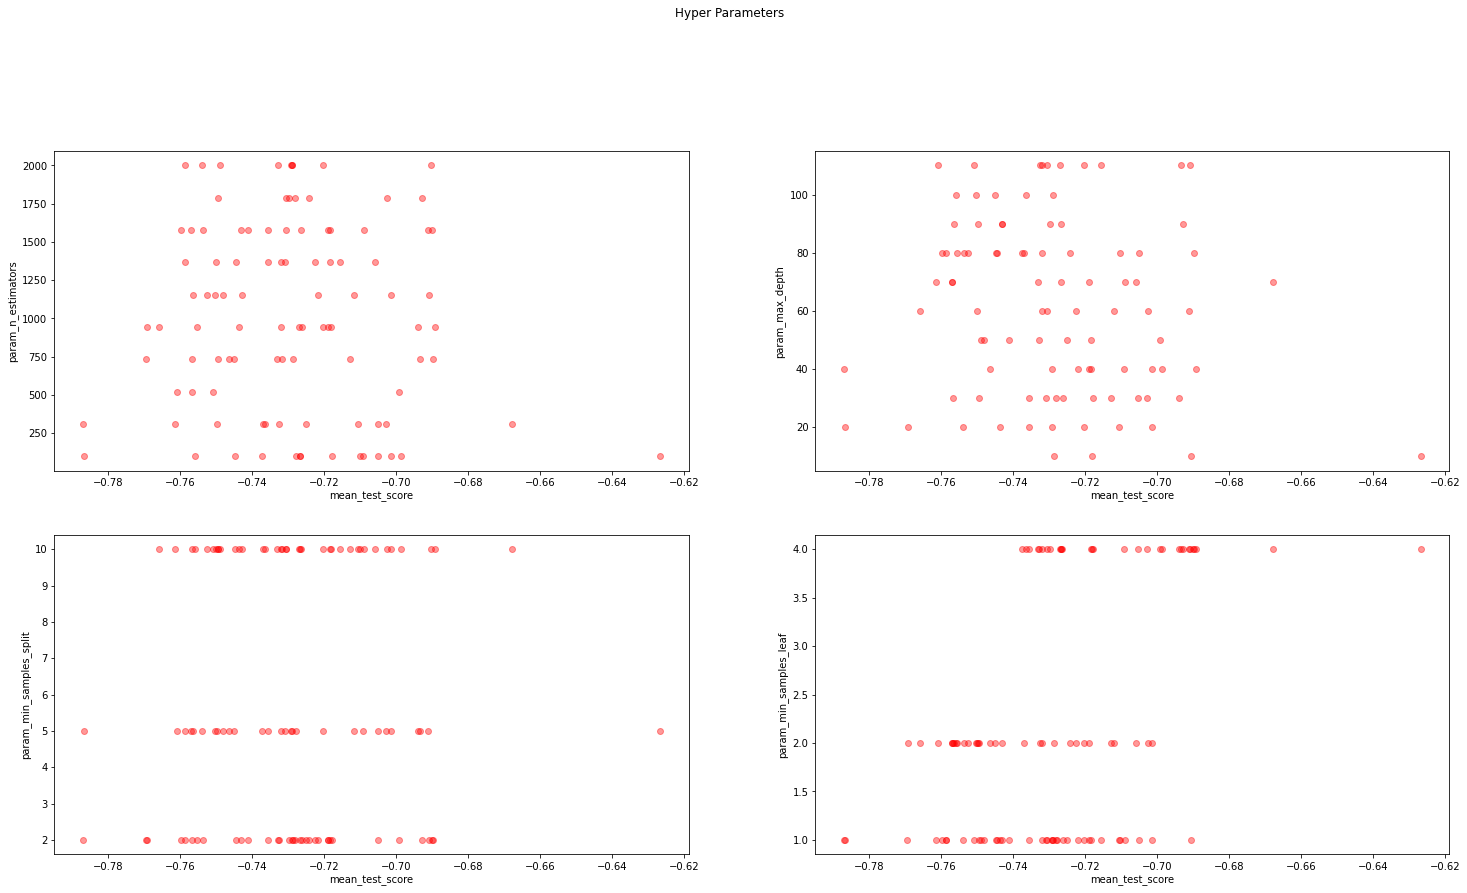

In [19]:
# Plot the hyper-parameters in relation of mean test score
# Values are plotted through dots. The brighter the dot, the more times that value has been chosen by the models.
# On the X axis, the closer the values are to 0 the better they are

h_params = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', ]
fig = plt.figure(figsize=(25, 20))
fig.suptitle('Hyper Parameters')
outer = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.2)
for index, h_param in enumerate(h_params):
    ax = plt.Subplot(fig, outer[index])
    ax.scatter(ris['mean_test_score'], ris[h_param], color='red', alpha=0.4, )
    ax.set_ylabel(h_param)
    ax.set_xlabel('mean_test_score')
    fig.add_subplot(ax)
fig.show()

## Feature Importance

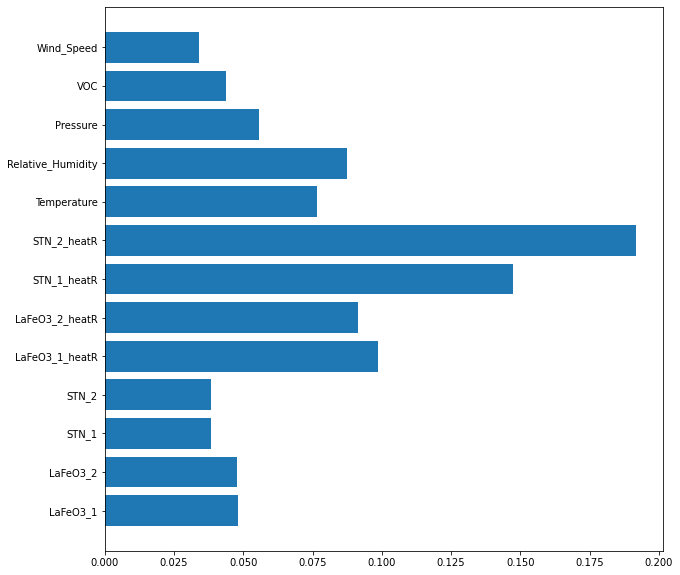

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(X_test.columns, rf_random.best_estimator_.feature_importances_)
plt.show()

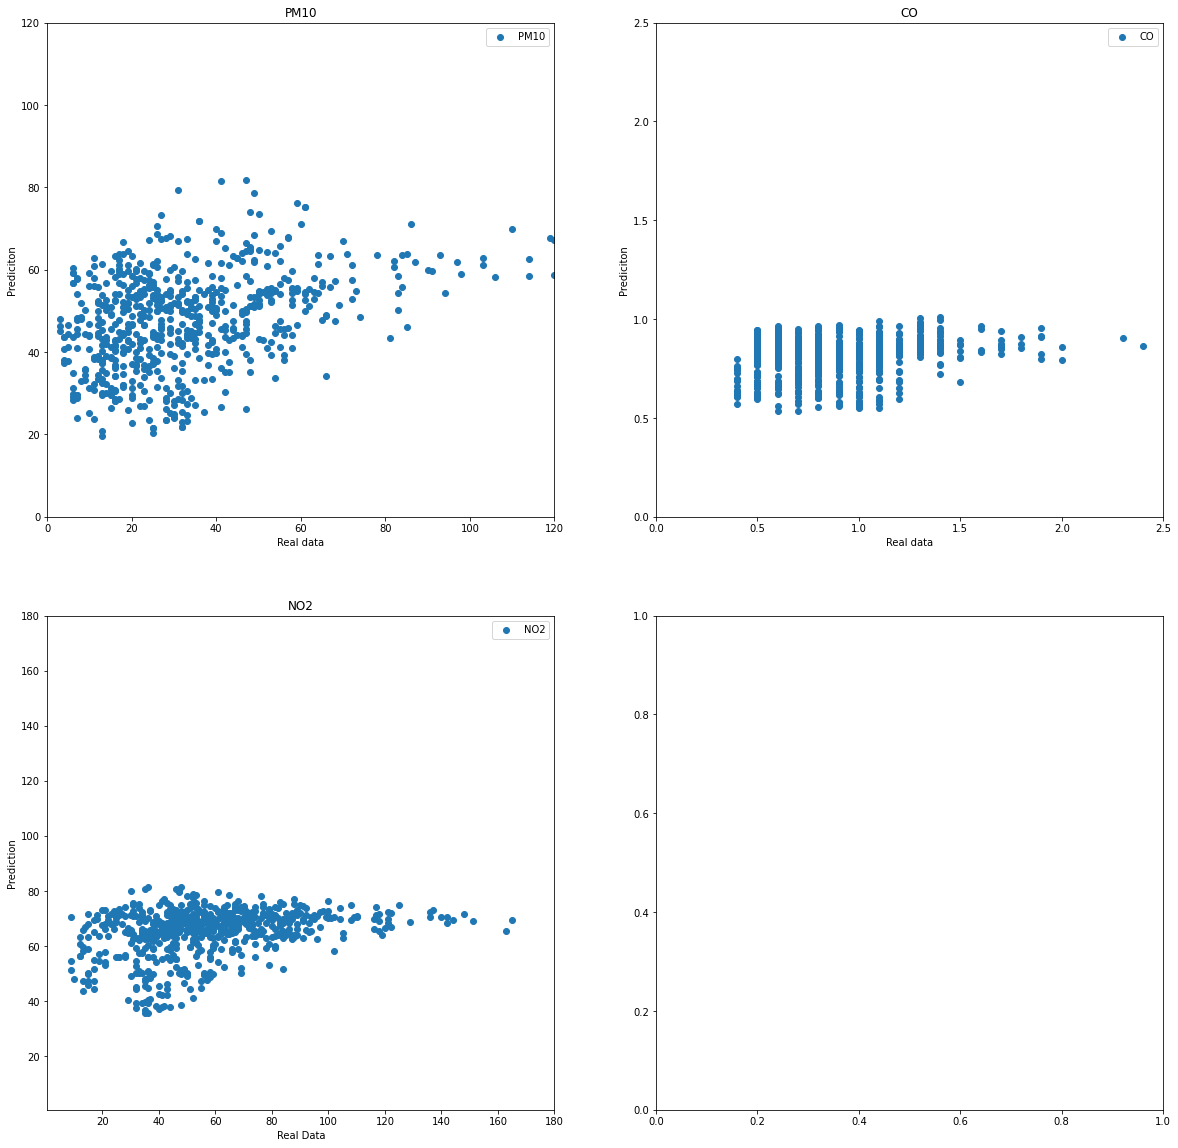

In [21]:
#Printing the charts to undersand better our predictions

fig,((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

ax1.scatter(Y_test.PM10, rf_random.predict(X_test)[:, 0], label = "PM10")
ax2.scatter(Y_test.CO, rf_random.predict(X_test)[:, 1], label = "CO")
ax3.scatter(Y_test.NO2, rf_random.predict(X_test)[:, 2], label = "NO2")

ax1.set_xlim(0, 120)
ax1.set_ylim(0, 120)
ax2.set_xlim(0, 2.5)
ax2.set_ylim(0, 2.5)
ax3.set_xlim(0.5, 180)
ax3.set_ylim(0.5, 180)

ax1.set_title('PM10')
ax1.set_xlabel('Real data')
ax1.set_ylabel('Prediciton')
ax2.set_title('CO')
ax2.set_xlabel('Real data')
ax2.set_ylabel('Prediciton')
ax3.set_title('NO2')
ax3.set_xlabel('Real Data')
ax3.set_ylabel('Prediction')

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_7636\1682026759.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


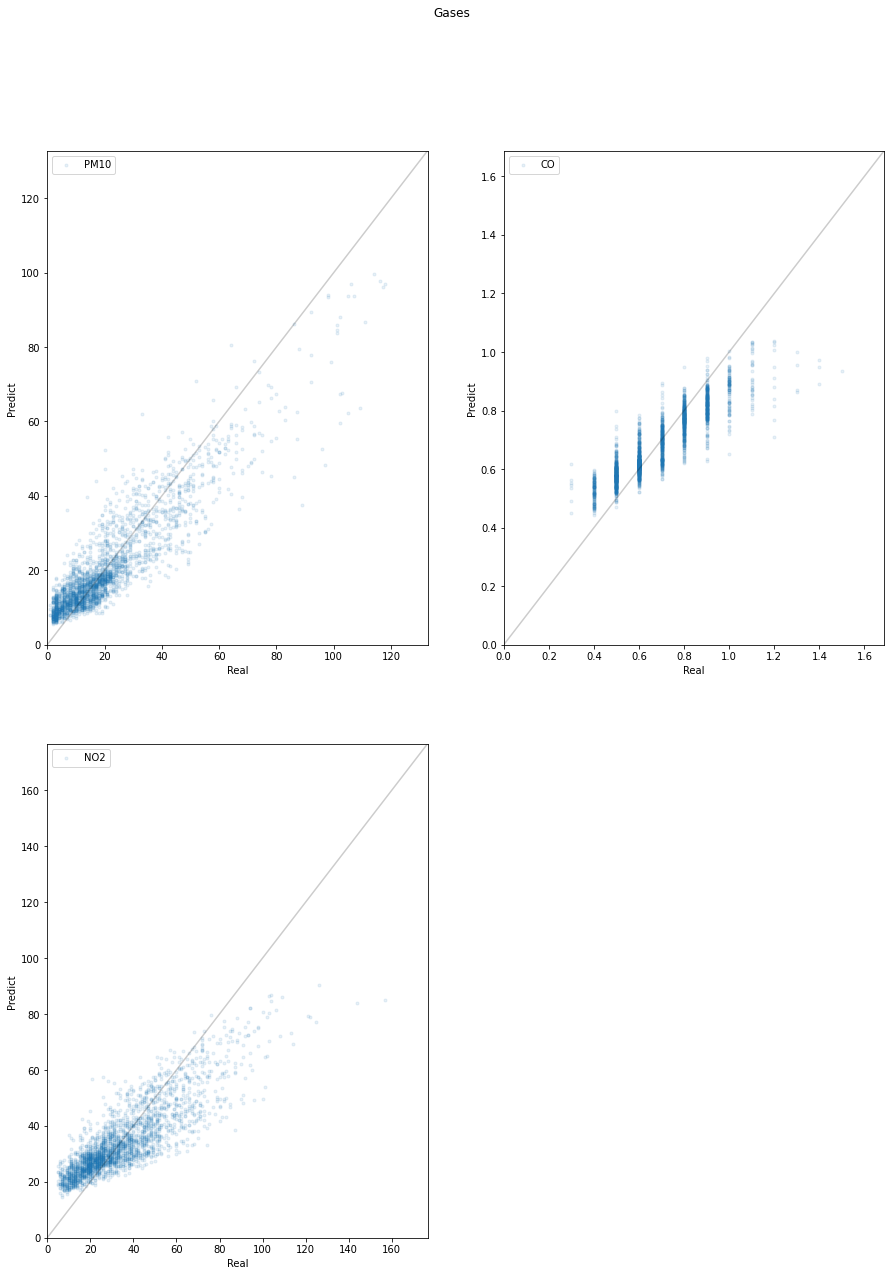

In [36]:
gases = Y_train.columns

fig = plt.figure(figsize=(15, 20))
fig.suptitle('Gases')
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)
for index, gas in enumerate(gases):
    ax = plt.Subplot(fig, outer[index])
    ax.scatter(Y_train[gas], rf_random.predict(X_train)[:,index], marker=".", alpha=0.1, label=gas)
    ax.set_xlabel(f"Real")
    ax.set_ylabel(f"Predict")
    ax.set_xlim(0, Y_train[gas].max()*9/8)
    ax.set_ylim(0, Y_train[gas].max()*9/8)
    ax.plot([-100, Y_train[gas].max()*10], [-100,  Y_train[gas].max()*10], c="k", alpha=0.2)
    ax.legend()
    fig.add_subplot(ax)
fig.show()

In [51]:
appa2.CO.describe()

count    3239.000000
mean        0.724359
std         0.228097
min         0.300000
25%         0.600000
50%         0.700000
75%         0.800000
max         2.600000
Name: CO, dtype: float64

In [52]:
appa2.CO.value_counts()

0.6    735
0.5    584
0.8    536
0.7    417
0.9    399
1.0    171
0.4    152
1.1    112
1.2     45
1.3     28
1.4     21
1.5      8
1.7      7
0.3      7
1.9      5
1.6      4
1.8      3
2.0      2
2.4      1
2.6      1
2.3      1
Name: CO, dtype: int64

In [48]:
Y_train.CO.value_counts()

0.6    659
0.5    503
0.8    453
0.7    356
0.9    326
0.4    134
1.0     99
1.1     35
1.2     11
0.3      7
1.3      4
1.4      3
1.5      1
Name: CO, dtype: int64

In [49]:
 Y_test.CO.value_counts()

0.8    83
0.5    81
1.1    77
0.6    76
0.9    73
1.0    72
0.7    61
1.2    34
1.3    24
1.4    18
0.4    18
1.5     7
1.7     7
1.9     5
1.6     4
1.8     3
2.0     2
2.3     1
2.6     1
2.4     1
Name: CO, dtype: int64